# Sparse Influence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
models = ['mlp_relu', 'mlp_leaky_relu', 'mlp_sigmoid', 'mlp_tanh', 'mlp_linear']
method = "Grad-Dot"

## Without Manual Manipulation

In [3]:
projections = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [4]:
def extract_metrics(file_path):
    # Data containers for each model
    data = {model: {'lds_scores': [], 'avg_sparsity_orig': [], 'avg_sparsity_proj': [], 'avg_dist_RE': []} for model in models}

    # Regular expressions for extracting the relevant metrics
    lds_regex = re.compile(r"lds: tensor\(([\d.-]+)\)")  # Handle both positive and negative values
    avg_sparsity_orig_regex = re.compile(r"Average Sparsity of Original Gradients: ([\d.]+)")
    avg_sparsity_proj_regex = re.compile(r"Average Sparsity of Projected Gradients: ([\d.]+)")
    avg_dist_RE_regex = re.compile(r"Average Distance Relative Error \(Original vs Projected\): ([\d.]+)")
    model_regex = re.compile(r"activation_fn', '(\w+)")

    current_model = None
    seen_lds = False  # To track if we've already captured the LDS value for the current projection

    with open(file_path, 'r') as file:
        for line in file:
            # Detect which model is being processed based on activation function
            model_match = model_regex.search(line)
            if model_match:
                activation_fn = model_match.group(1)
                current_model = f"mlp_{activation_fn}"
                seen_lds = False  # Reset LDS flag when switching to a new model

            if current_model:
                # Extract LDS scores (only the first time it appears per model/projection)
                if not seen_lds:
                    lds_match = lds_regex.search(line)
                    if lds_match:
                        lds_score = float(lds_match.group(1))
                        data[current_model]['lds_scores'].append(lds_score)
                        seen_lds = True  # Mark LDS as captured for this projection

                # Extract Average Sparsity of Original Gradients
                avg_sparsity_orig_match = avg_sparsity_orig_regex.search(line)
                if avg_sparsity_orig_match:
                    avg_sparsity_orig = float(avg_sparsity_orig_match.group(1))
                    data[current_model]['avg_sparsity_orig'].append(avg_sparsity_orig)

                # Extract Average Sparsity of Projected Gradients
                avg_sparsity_proj_match = avg_sparsity_proj_regex.search(line)
                if avg_sparsity_proj_match:
                    avg_sparsity_proj = float(avg_sparsity_proj_match.group(1))
                    data[current_model]['avg_sparsity_proj'].append(avg_sparsity_proj)

                # Extract Average Distance Relative Error
                avg_dist_RE_match = avg_dist_RE_regex.search(line)
                if avg_dist_RE_match:
                    avg_dist_RE = float(avg_dist_RE_match.group(1))
                    data[current_model]['avg_dist_RE'].append(avg_dist_RE)

    return data

def plot_metrics(data, projections, metric='lds_scores'):
    if metric == 'sparsity':
        # For sparsity metrics, use a bar plot
        plot_sparsity(data)
    else:
        # Default to line plot for other metrics like LDS or distance correlation
        plt.figure(figsize=(10, 6))
        for model in data:
            plt.plot(projections, data[model][metric], marker='o', linestyle='-', label=model)

        # Labels and title
        plt.xlabel('Projection Dimension')
        if metric == 'lds_scores':
            plt.ylabel('LDS (Linear Datamodeling Score)')
            plt.title('LDS Scores for Different Models Across Projection Dimensions')
        elif metric == 'avg_dist_RE':
            plt.ylabel('Average Distance Relative Error')
            plt.title('Average Distance Relative Error Across Projection Dimensions')

        plt.xticks(projections)
        plt.legend()

        # Show plot
        plt.show()

def plot_sparsity(data):
    # Bar plot for sparsity metrics (average sparsity of original and projected gradients)
    models = list(data.keys())
    orig_sparsity = [np.mean(data[model]['avg_sparsity_orig']) for model in models]
    proj_sparsity = [np.mean(data[model]['avg_sparsity_proj']) for model in models]

    x = np.arange(len(models))  # Model indices for the x-axis
    width = 0.35  # Width of bars

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot bars for original and projected sparsity
    plt.bar(x - width/2, orig_sparsity, width, label='Original Sparsity', color='skyblue')
    plt.bar(x + width/2, proj_sparsity, width, label='Projected Sparsity', color='salmon')

    # Labels and title
    plt.ylabel('Sparsity')
    plt.title('Comparison of Original and Projected Sparsity for Different Models')

    # Set the x-axis ticks to model names
    plt.xticks(x, models)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

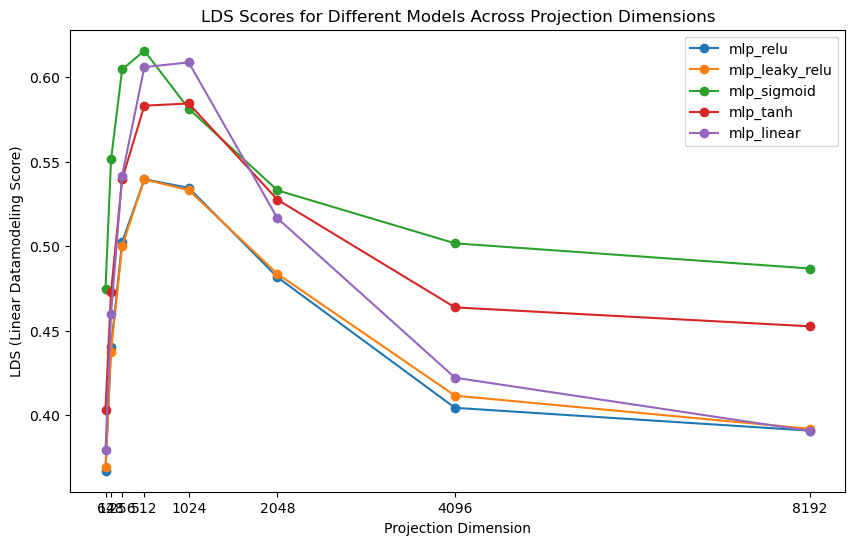

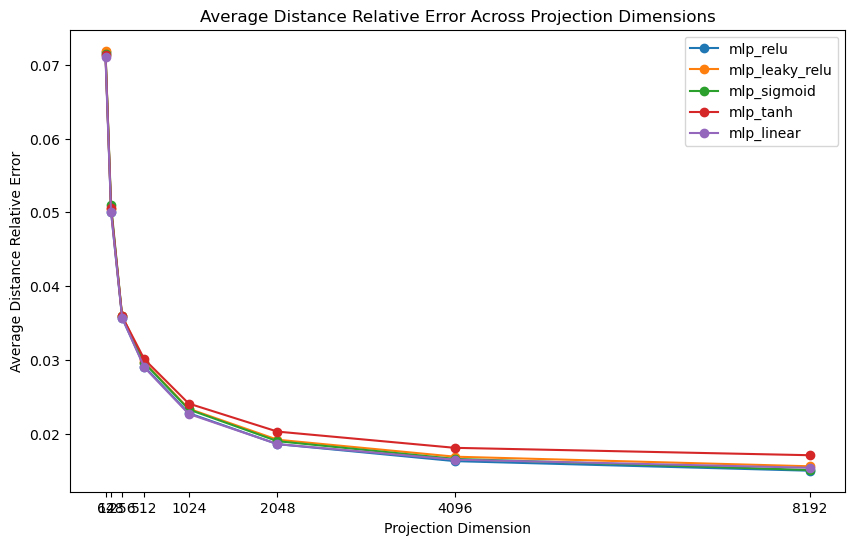

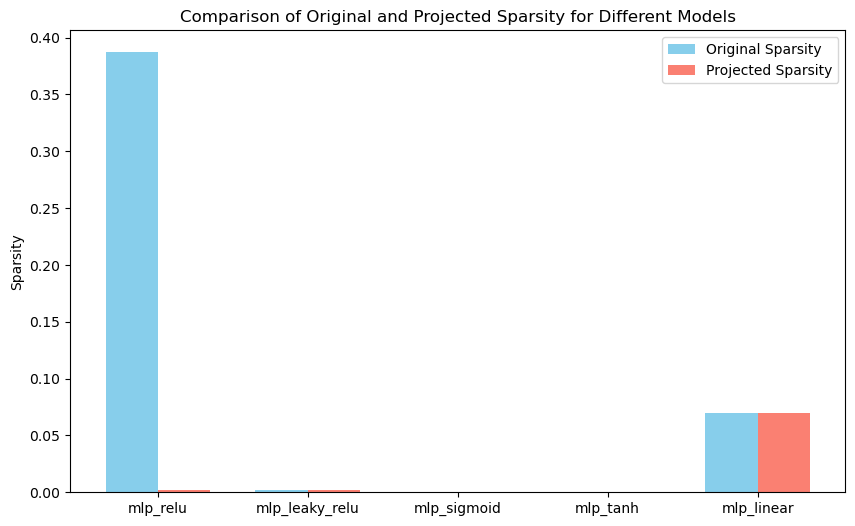

In [5]:
log_file_path = f'./result/evaluate/{method}/original.out'
data = extract_metrics(log_file_path)
# for metric in ['lds_scores', 'avg_dist_RE', 'avg_dist_RMSE', 'avg_dist_stress', 'sparsity']:
#     plot_metrics(data, projections, metric=metric)

for metric in ['lds_scores', 'avg_dist_RE', 'sparsity']:
    plot_metrics(data, projections, metric=metric)

In [6]:
print(data["mlp_linear"]['avg_sparsity_proj'])
print(data["mlp_linear"]['avg_sparsity_orig'])

[0.0697, 0.0697, 0.0697, 0.0695, 0.0695, 0.0695, 0.0695, 0.0695]
[0.0697, 0.0697, 0.0697, 0.0695, 0.0695, 0.0695, 0.0695, 0.0695]


## Random Zeroed-Out

For every gradient, randomly setting entries to $0$ with $\mathrm{drop\_rate} \times \text{\#parameters}$.

In [7]:
# projections = [64, 128, 256]
drop_rates = ["0.1", "0.2", "0.3", "0.4", "0.5"]

def extract_metrics_with_drop_rate(file_path):
    # Data containers for each model and drop rate
    data = {model: {drop_rate: {'lds_scores': [], 'avg_sparsity_orig': [], 'avg_sparsity_proj': [], 'avg_dist_RE': []}
                    for drop_rate in drop_rates}
            for model in models}

    # Regular expressions for extracting the relevant metrics
    lds_regex = re.compile(r"lds: tensor\(([\d.-]+)\)")  # Handle both positive and negative values
    avg_sparsity_orig_regex = re.compile(r"Average Sparsity of Original Gradients: ([\d.]+)")
    avg_sparsity_proj_regex = re.compile(r"Average Sparsity of Projected Gradients: ([\d.]+)")
    avg_dist_RE_regex = re.compile(r"Average Distance Relative Error \(Original vs Projected\): ([\d.]+)")
    model_regex = re.compile(r"activation_fn', '(\w+)")
    drop_rate_regex = re.compile(r"sparsify='random-([\d.]+)'")

    current_model = None
    current_drop_rate = None
    seen_lds = False  # To track if we've already captured the LDS value for the current projection

    with open(file_path, 'r') as file:
        for line in file:
            # Detect which model is being processed based on activation function
            model_match = model_regex.search(line)
            if model_match:
                activation_fn = model_match.group(1)
                current_model = f"mlp_{activation_fn}"
                seen_lds = False  # Reset LDS flag when switching to a new model

            # Detect the drop rate
            drop_rate_match = drop_rate_regex.search(line)
            if drop_rate_match:
                current_drop_rate = drop_rate_match.group(1)
                seen_lds = False  # Reset LDS flag for each new drop rate

            if current_model and current_drop_rate:
                # Extract LDS scores (only the first time it appears per model/projection)
                if not seen_lds:
                    lds_match = lds_regex.search(line)
                    if lds_match:
                        lds_score = float(lds_match.group(1))
                        data[current_model][current_drop_rate]['lds_scores'].append(lds_score)
                        seen_lds = True  # Mark LDS as captured for this projection

                # Extract Average Sparsity of Original Gradients
                avg_sparsity_orig_match = avg_sparsity_orig_regex.search(line)
                if avg_sparsity_orig_match:
                    avg_sparsity_orig = float(avg_sparsity_orig_match.group(1))
                    data[current_model][current_drop_rate]['avg_sparsity_orig'].append(avg_sparsity_orig)

                # Extract Average Sparsity of Projected Gradients
                avg_sparsity_proj_match = avg_sparsity_proj_regex.search(line)
                if avg_sparsity_proj_match:
                    avg_sparsity_proj = float(avg_sparsity_proj_match.group(1))
                    data[current_model][current_drop_rate]['avg_sparsity_proj'].append(avg_sparsity_proj)

                # Extract Average Relative Error
                avg_RE_match = avg_dist_RE_regex.search(line)
                if avg_RE_match:
                    avg_RE = float(avg_RE_match.group(1))
                    data[current_model][current_drop_rate]['avg_dist_RE'].append(avg_RE)

    return data

log_file_path = f'./result/evaluate/{method}/random.out'
data = extract_metrics_with_drop_rate(log_file_path)

In [8]:
def plot_metrics_with_drop_rate(data, projections, drop_rates, metric='lds_scores'):
    num_drop_rates = len(drop_rates)

    # Create a grid of subplots for each drop rate
    fig, axes = plt.subplots(1, num_drop_rates, figsize=(6 * num_drop_rates, 6), sharey=True)

    # Loop over drop rates and create a line plot for each
    for i, drop_rate in enumerate(drop_rates):
        ax = axes[i] if num_drop_rates > 1 else axes  # Handle case of single drop_rate

        # Plot each model's data for the current drop_rate
        for model in data:
            model_data = data[model][drop_rate][metric]
            ax.plot(projections, model_data, marker='o', linestyle='-', label=model)

        # Labels and title for each subplot
        ax.set_xlabel('Projection Dimension')
        ax.set_xticks(projections)
        if metric == 'lds_scores':
            ax.set_ylabel('LDS (Linear Datamodeling Score)')
            ax.set_title(f'drop_rate={drop_rate}')
        elif metric == 'avg_dist_RE':
            ax.set_ylabel('Average Distance Relative Error')
            ax.set_title(f'drop_rate={drop_rate}')

        ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

def plot_metrics_with_proj_dim_drop_rate(data, projections, drop_rates, metric='lds_scores'):
    num_projections = len(projections)
    num_drop_rates = len(drop_rates)

    # Create a grid of subplots for each projection dimension
    fig, axes = plt.subplots(1, num_projections, figsize=(6 * num_projections, 6), sharey=True)

    # Loop over projection dimensions and create a line plot for each
    for i, proj_dim in enumerate(projections):
        ax = axes[i] if num_projections > 1 else axes  # Handle case of single proj_dim

        # Plot each model's data for the current proj_dim across drop_rates
        for model in data:
            model_data = [data[model][drop_rate][metric][i] for drop_rate in drop_rates]
            ax.plot(drop_rates, model_data, marker='o', linestyle='-', label=model)

        # Labels and title for each subplot
        ax.set_xlabel('Drop Rate')
        ax.set_xticks(drop_rates)
        if metric == 'lds_scores':
            ax.set_ylabel('LDS (Linear Datamodeling Score)')
            ax.set_title(f'LDS Scores Across Drop Rates (proj_dim={proj_dim})')
        elif metric == 'avg_dist_RE':
            ax.set_ylabel('Average Distance Relative Error')
            ax.set_title(f'Avg Dist Relative Error Across Drop Rates (proj_dim={proj_dim})')

        ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

def plot_sparsity_with_drop_rate(data, drop_rates):
    num_drop_rates = len(drop_rates)
    models = list(data.keys())

    fig, axes = plt.subplots(1, num_drop_rates, figsize=(6 * num_drop_rates, 6), sharey=True)

    # Loop over drop rates to create bar plots for each
    for i, drop_rate in enumerate(drop_rates):
        ax = axes[i] if len(drop_rates) > 1 else axes  # Handle case of single drop_rate

        orig_sparsity = [np.mean(data[model][drop_rate]['avg_sparsity_orig']) for model in models]
        proj_sparsity = [np.mean(data[model][drop_rate]['avg_sparsity_proj']) for model in models]

        x = np.arange(len(models))  # Model indices for the x-axis
        width = 0.35  # Width of bars

        # Plot bars for original and projected sparsity
        ax.bar(x - width/2, orig_sparsity, width, label='Original Sparsity', color='skyblue')
        ax.bar(x + width/2, proj_sparsity, width, label='Projected Sparsity', color='salmon')

        # Labels and title
        ax.set_ylabel('Sparsity')
        ax.set_title(f'Original and Projected Sparsity for Models (drop_rate={drop_rate})')
        ax.set_xticks(x)
        ax.set_xticklabels(models)

        ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

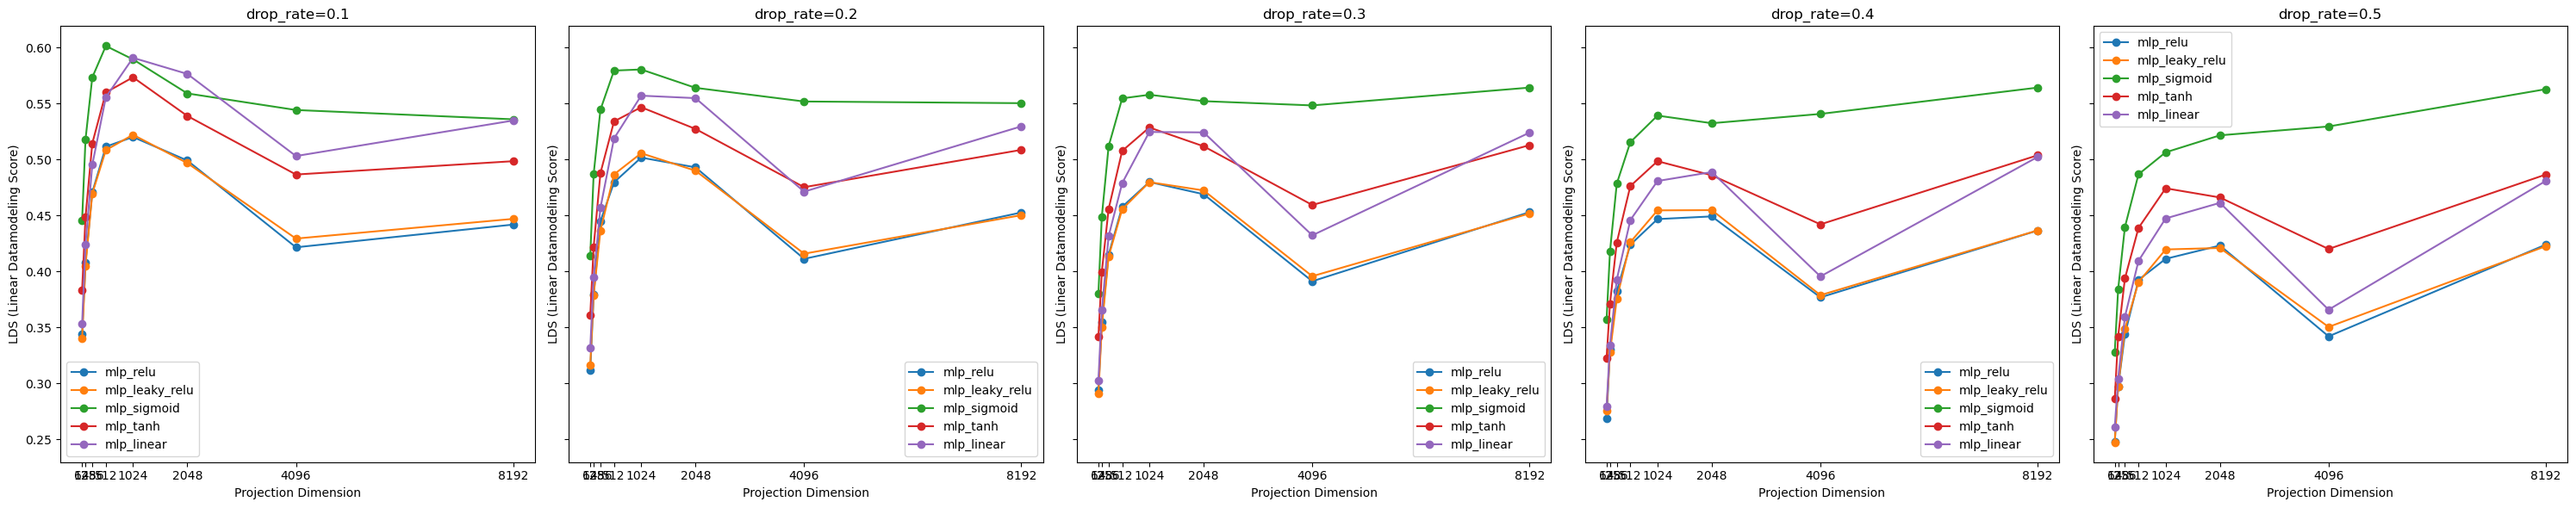

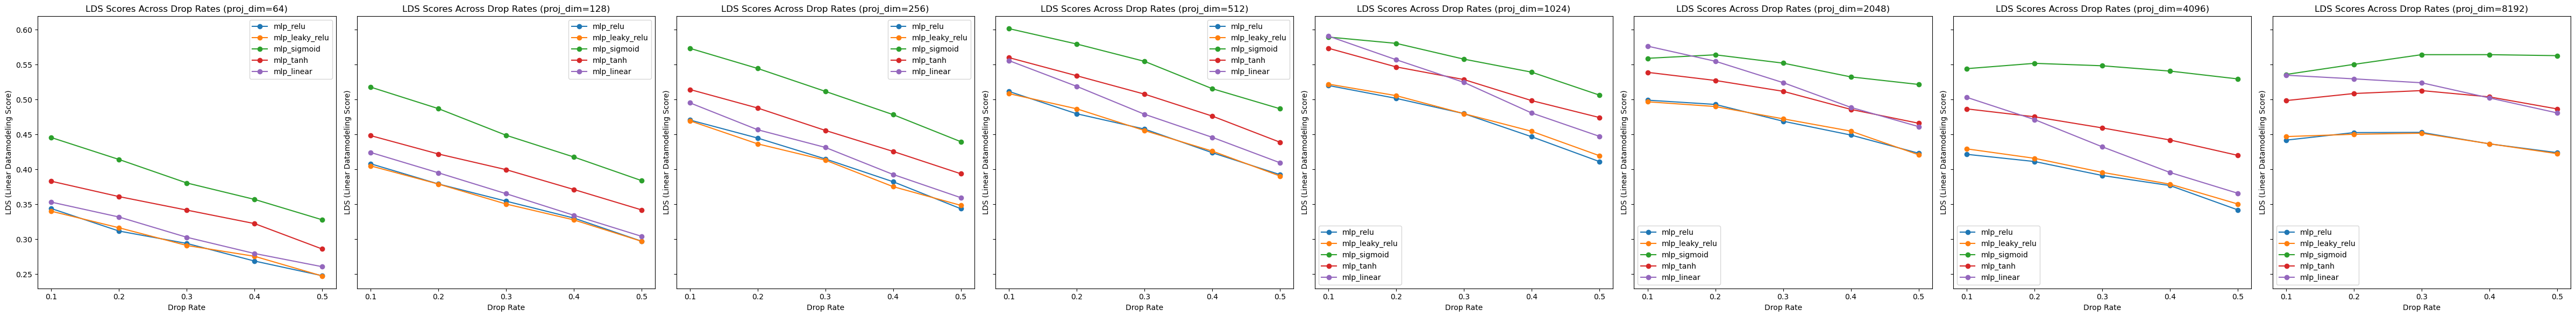

In [9]:
plot_metrics_with_drop_rate(data, projections, drop_rates, metric='lds_scores')
plot_metrics_with_proj_dim_drop_rate(data, projections, drop_rates, metric='lds_scores')

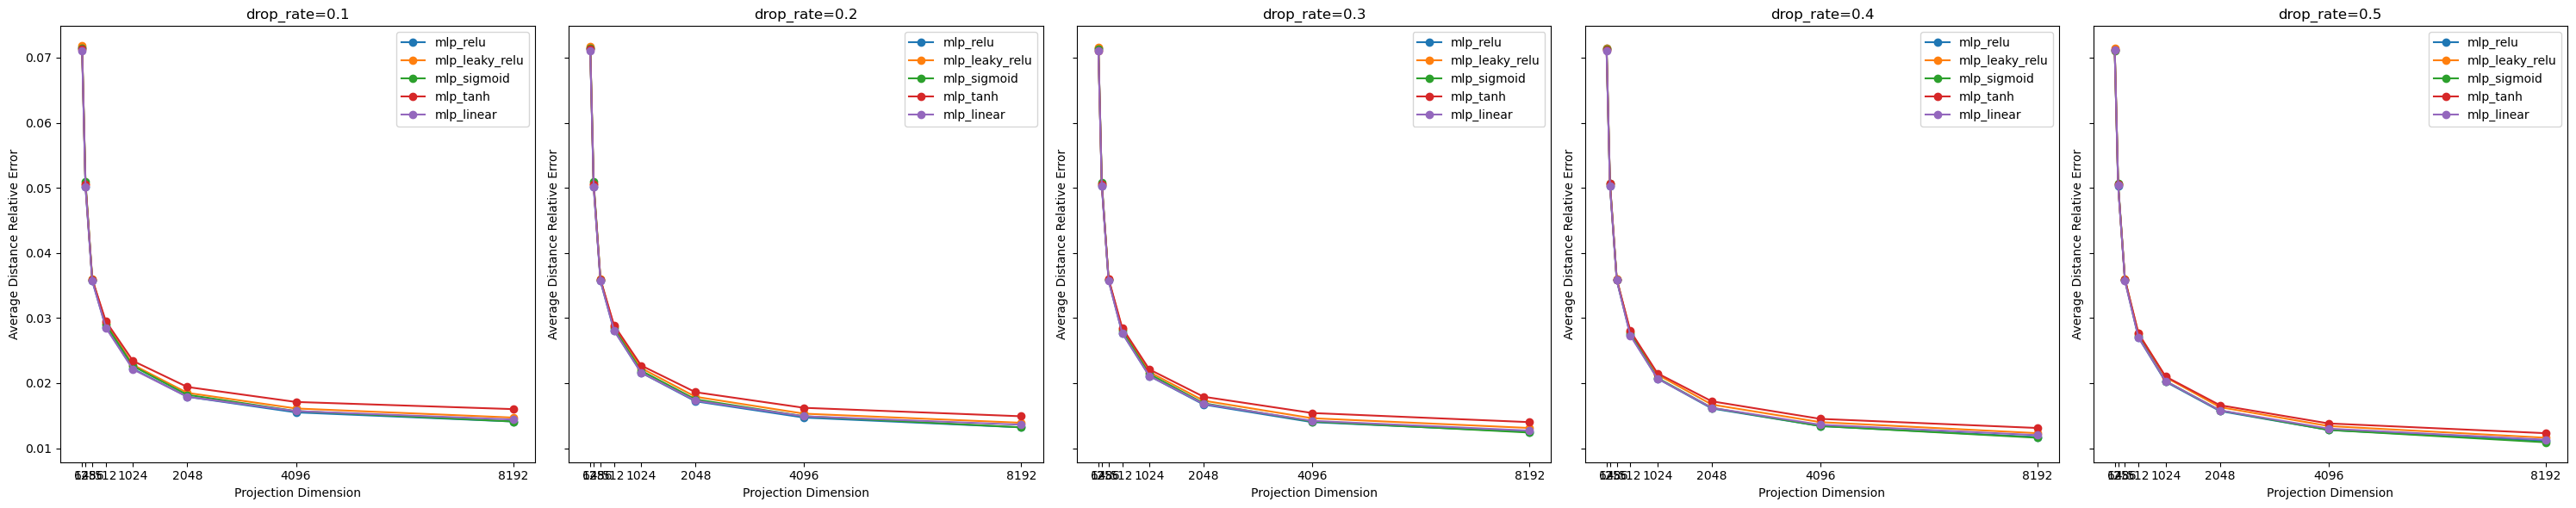

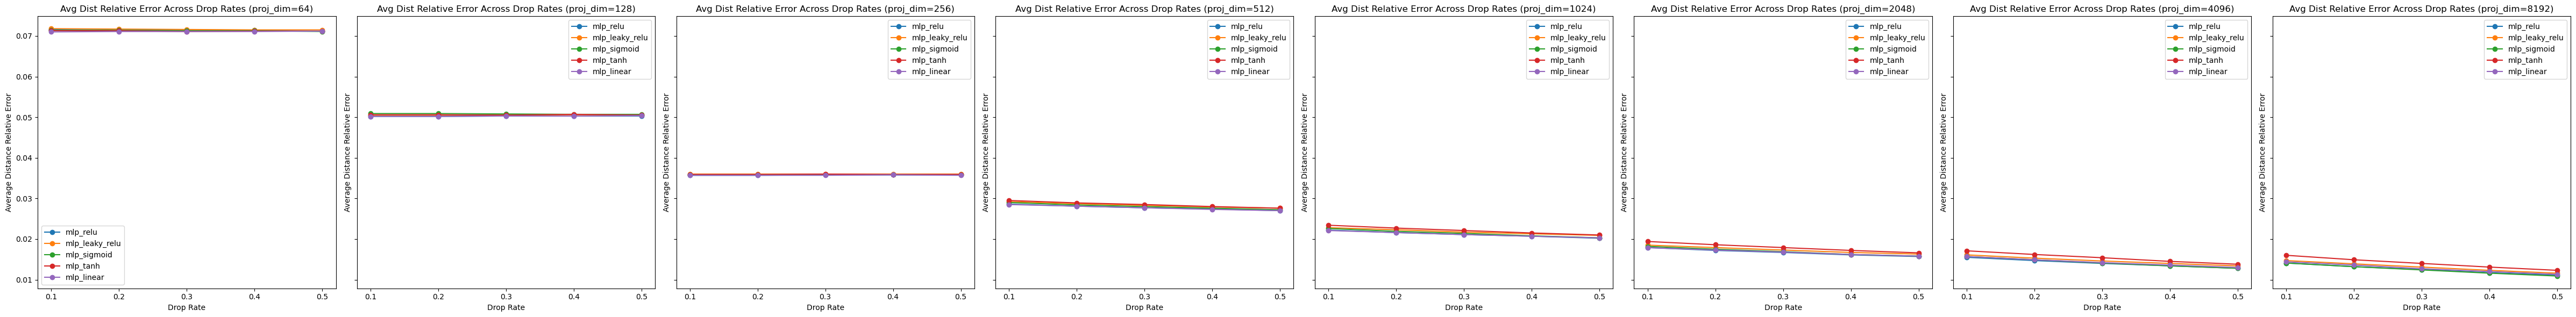

In [10]:
# for metric in ['avg_dist_RE', 'avg_dist_RMSE', 'avg_dist_stress']:
#     plot_metrics_with_drop_rate(data, projections, drop_rates, metric=metric)
#     plot_metrics_with_proj_dim_drop_rate(data, projections, drop_rates, metric=metric)
for metric in ['avg_dist_RE']:
    plot_metrics_with_drop_rate(data, projections, drop_rates, metric=metric)
    plot_metrics_with_proj_dim_drop_rate(data, projections, drop_rates, metric=metric)

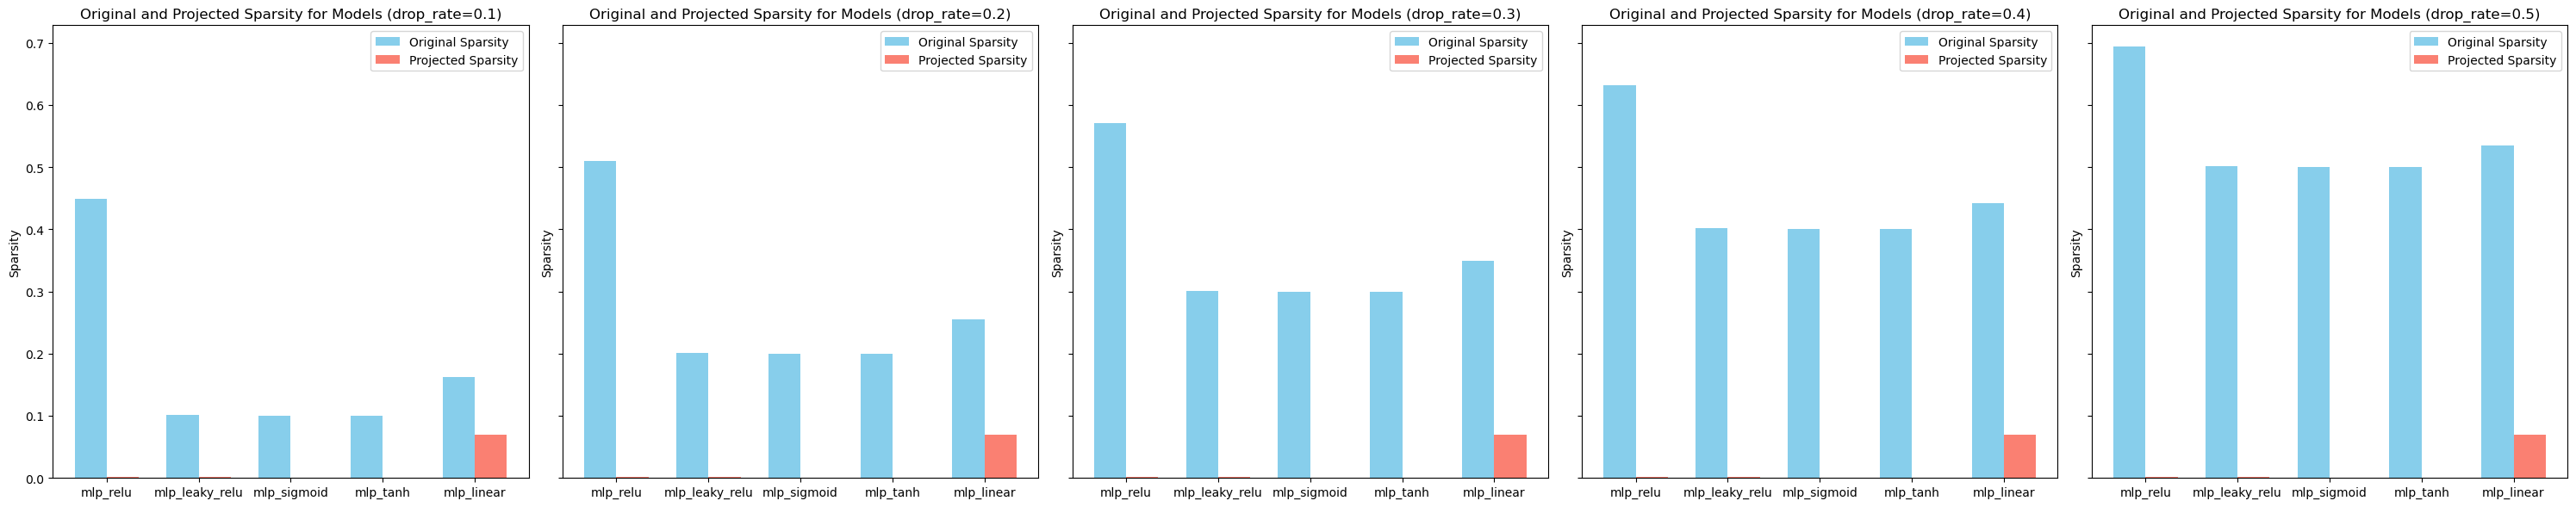

In [11]:
plot_sparsity_with_drop_rate(data, drop_rates)

## Threshold

In [12]:
# projections = [64, 128, 256]
eps_list = ["0.0000001", "0.000001", "0.00001", "0.0001", "0.001"]

def extract_metrics_with_threshold(file_path):
    # Data containers for each model and threshold
    data = {model: {eps: {'lds_scores': [], 'avg_sparsity_orig': [], 'avg_sparsity_proj': [], 'avg_dist_RE': []}
                    for eps in eps_list}
            for model in models}

    # Regular expressions for extracting the relevant metrics
    lds_regex = re.compile(r"lds: tensor\(([\d.-]+)\)")  # Handle both positive and negative values
    avg_sparsity_orig_regex = re.compile(r"Average Sparsity of Original Gradients: ([\d.]+)")
    avg_sparsity_proj_regex = re.compile(r"Average Sparsity of Projected Gradients: ([\d.]+)")
    avg_dist_RE_regex = re.compile(r"Average Distance Relative Error \(Original vs Projected\): ([\d.]+)")
    model_regex = re.compile(r"activation_fn', '(\w+)")
    threshold_regex = re.compile(r"sparsify='threshold-([\d.]+)'")

    current_model = None
    current_eps = None
    seen_lds = False  # To track if we've already captured the LDS value for the current projection

    with open(file_path, 'r') as file:
        for line in file:
            # Detect which model is being processed based on activation function
            model_match = model_regex.search(line)
            if model_match:
                activation_fn = model_match.group(1)
                current_model = f"mlp_{activation_fn}"
                seen_lds = False  # Reset LDS flag when switching to a new model

            # Detect the epsilon
            threshold_match = threshold_regex.search(line)
            if threshold_match:
                current_eps = threshold_match.group(1)
                seen_lds = False  # Reset LDS flag for each new epsilon

            if current_model and current_eps:
                # Extract LDS scores (only the first time it appears per model/projection)
                if not seen_lds:
                    lds_match = lds_regex.search(line)
                    if lds_match:
                        lds_score = float(lds_match.group(1))
                        data[current_model][current_eps]['lds_scores'].append(lds_score)
                        seen_lds = True  # Mark LDS as captured for this projection

                # Extract Average Sparsity of Original Gradients
                avg_sparsity_orig_match = avg_sparsity_orig_regex.search(line)
                if avg_sparsity_orig_match:
                    avg_sparsity_orig = float(avg_sparsity_orig_match.group(1))
                    data[current_model][current_eps]['avg_sparsity_orig'].append(avg_sparsity_orig)

                # Extract Average Sparsity of Projected Gradients
                avg_sparsity_proj_match = avg_sparsity_proj_regex.search(line)
                if avg_sparsity_proj_match:
                    avg_sparsity_proj = float(avg_sparsity_proj_match.group(1))
                    data[current_model][current_eps]['avg_sparsity_proj'].append(avg_sparsity_proj)

                # Extract Average Relative Error
                avg_RE_match = avg_dist_RE_regex.search(line)
                if avg_RE_match:
                    avg_RE = float(avg_RE_match.group(1))
                    data[current_model][current_eps]['avg_dist_RE'].append(avg_RE)

    return data

log_file_path = f'./result/evaluate/{method}/threshold.out'
data = extract_metrics_with_threshold(log_file_path)

In [13]:
def plot_metrics_with_threshold(data, projections, eps_list, metric='lds_scores'):
    num_eps = len(eps_list)

    # Create a grid of subplots for each eps
    fig, axes = plt.subplots(1, num_eps, figsize=(6 * num_eps, 6), sharey=True)

    # Loop over eps and create a line plot for each
    for i, eps in enumerate(eps_list):
        ax = axes[i] if num_eps > 1 else axes  # Handle case of single eps

        # Plot each model's data for the current eps
        for model in data:
            model_data = data[model][eps][metric]
            ax.plot(projections, model_data, marker='o', linestyle='-', label=model)

        # Labels and title for each subplot
        ax.set_xlabel('Projection Dimension')
        ax.set_xticks(projections)
        if metric == 'lds_scores':
            ax.set_ylabel('LDS (Linear Datamodeling Score)')
            ax.set_title(f'eps={eps}')
        elif metric == 'avg_dist_RE':
            ax.set_ylabel('Average Distance Relative Error')
            ax.set_title(f'$\epsilon$={eps}')

        ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

def plot_metrics_with_proj_dim_threshold(data, projections, eps_list, metric='lds_scores'):
    num_projections = len(projections)

    # Create a grid of subplots for each projection dimension
    fig, axes = plt.subplots(1, num_projections, figsize=(6 * num_projections, 6), sharey=True)

    # Loop over projection dimensions and create a line plot for each
    for i, proj_dim in enumerate(projections):
        ax = axes[i] if num_projections > 1 else axes  # Handle case of single proj_dim

        # Plot each model's data for the current proj_dim across epsilons
        for model in data:
            model_data = [data[model][eps][metric][i] for eps in eps_list]
            ax.plot(eps_list, model_data, marker='o', linestyle='-', label=model)

        # Labels and title for each subplot
        ax.set_xlabel('$\epsilon$')
        ax.set_xticks(eps_list)
        if metric == 'lds_scores':
            ax.set_ylabel('LDS (Linear Datamodeling Score)')
            ax.set_title(f'LDS Scores Across $\epsilon$ (proj_dim={proj_dim})')
        elif metric == 'avg_dist_RE':
            ax.set_ylabel('Average Distance Relative Error')
            ax.set_title(f'Avg Dist Relative Error Across $\epsilon$ (proj_dim={proj_dim})')

        ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

def plot_sparsity_with_threshold(data, eps_list):
    num_eps = len(eps_list)
    models = list(data.keys())

    fig, axes = plt.subplots(1, num_eps, figsize=(6 * num_eps, 6), sharey=True)

    # Loop over drop rates to create bar plots for each
    for i, eps in enumerate(eps_list):
        ax = axes[i] if num_eps > 1 else axes  # Handle case of single eps

        orig_sparsity = [np.mean(data[model][eps]['avg_sparsity_orig']) for model in models]
        proj_sparsity = [np.mean(data[model][eps]['avg_sparsity_proj']) for model in models]

        x = np.arange(len(models))  # Model indices for the x-axis
        width = 0.35  # Width of bars

        # Plot bars for original and projected sparsity
        ax.bar(x - width/2, orig_sparsity, width, label='Original Sparsity', color='skyblue')
        ax.bar(x + width/2, proj_sparsity, width, label='Projected Sparsity', color='salmon')

        # Labels and title
        ax.set_ylabel('Sparsity')
        ax.set_title(f'Original and Projected Sparsity for Models ($\epsilon$={eps})')
        ax.set_xticks(x)
        ax.set_xticklabels(models)

        ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

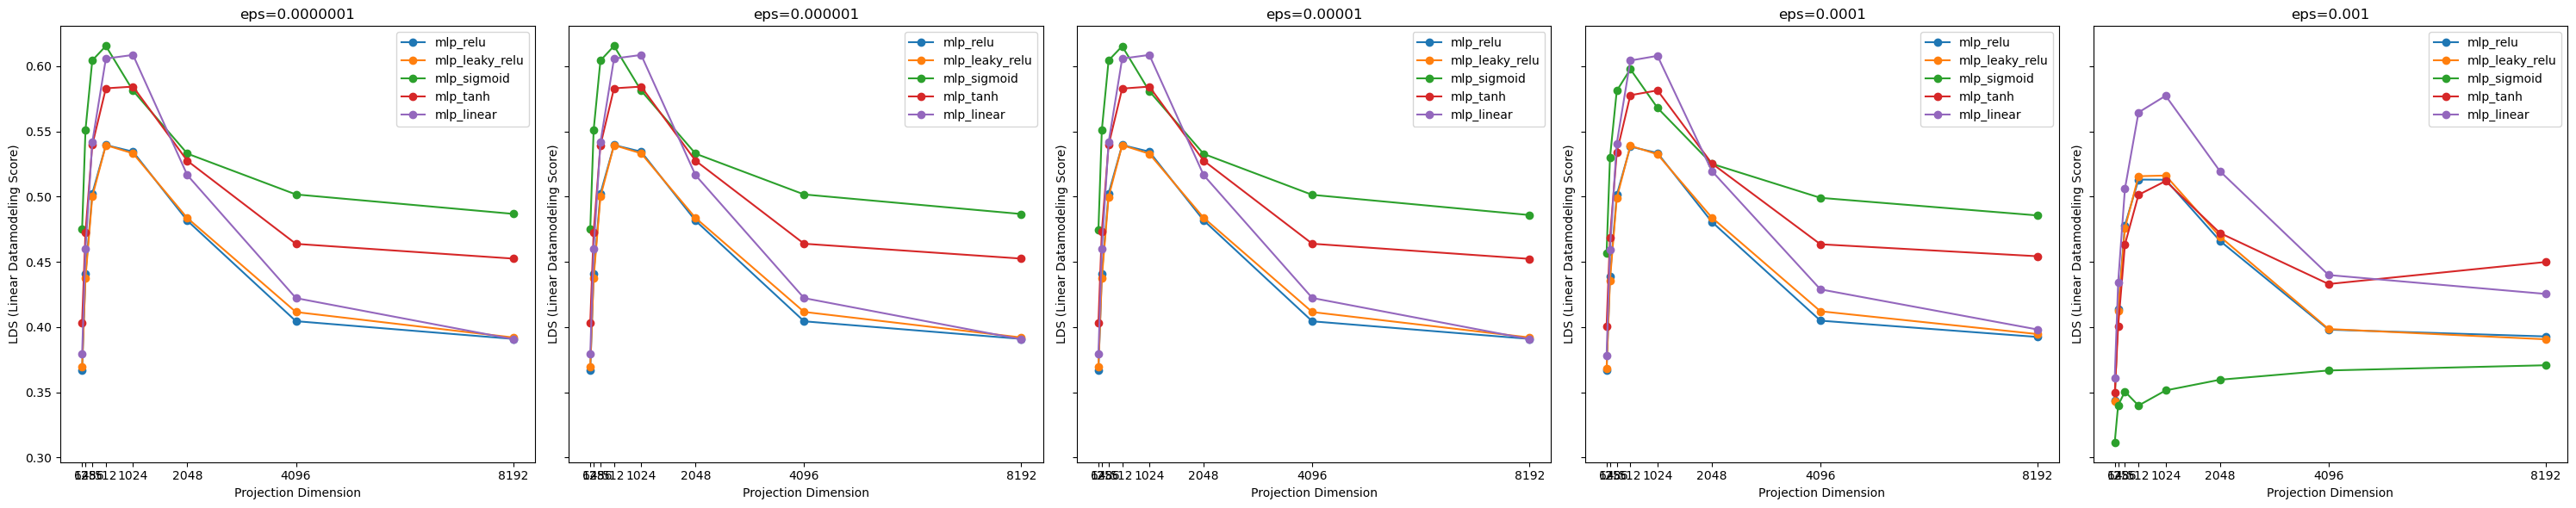

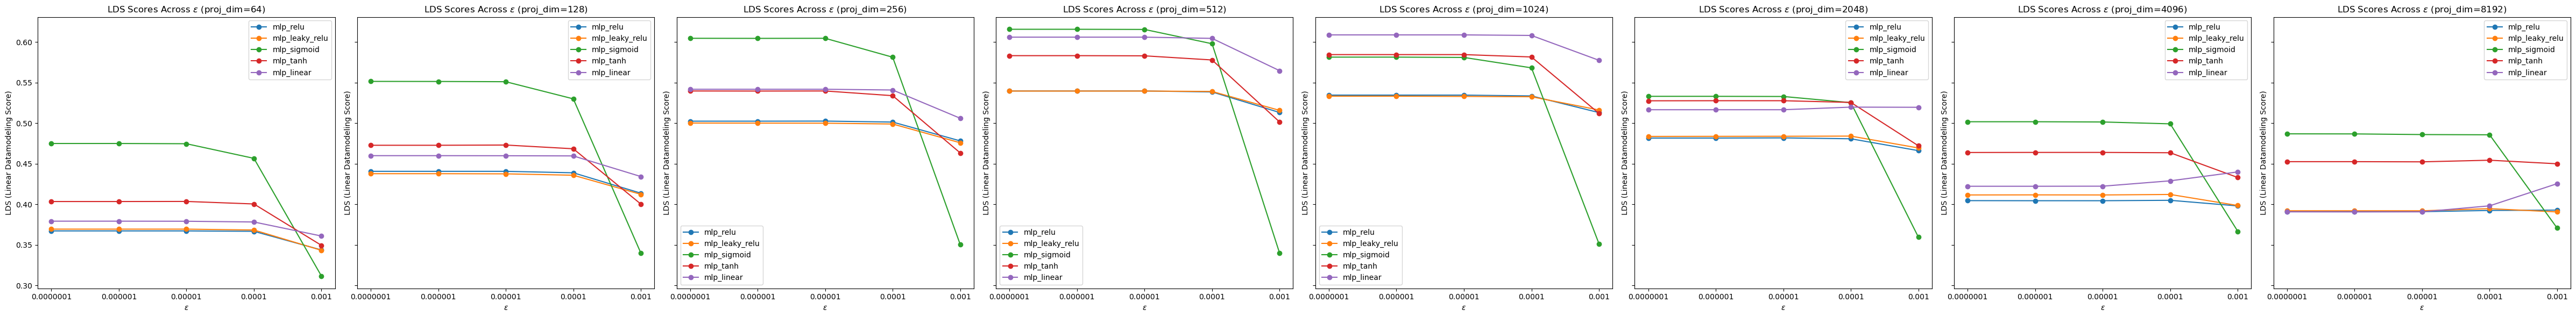

In [14]:
plot_metrics_with_threshold(data, projections, eps_list, metric='lds_scores')
plot_metrics_with_proj_dim_threshold(data, projections, eps_list, metric='lds_scores')

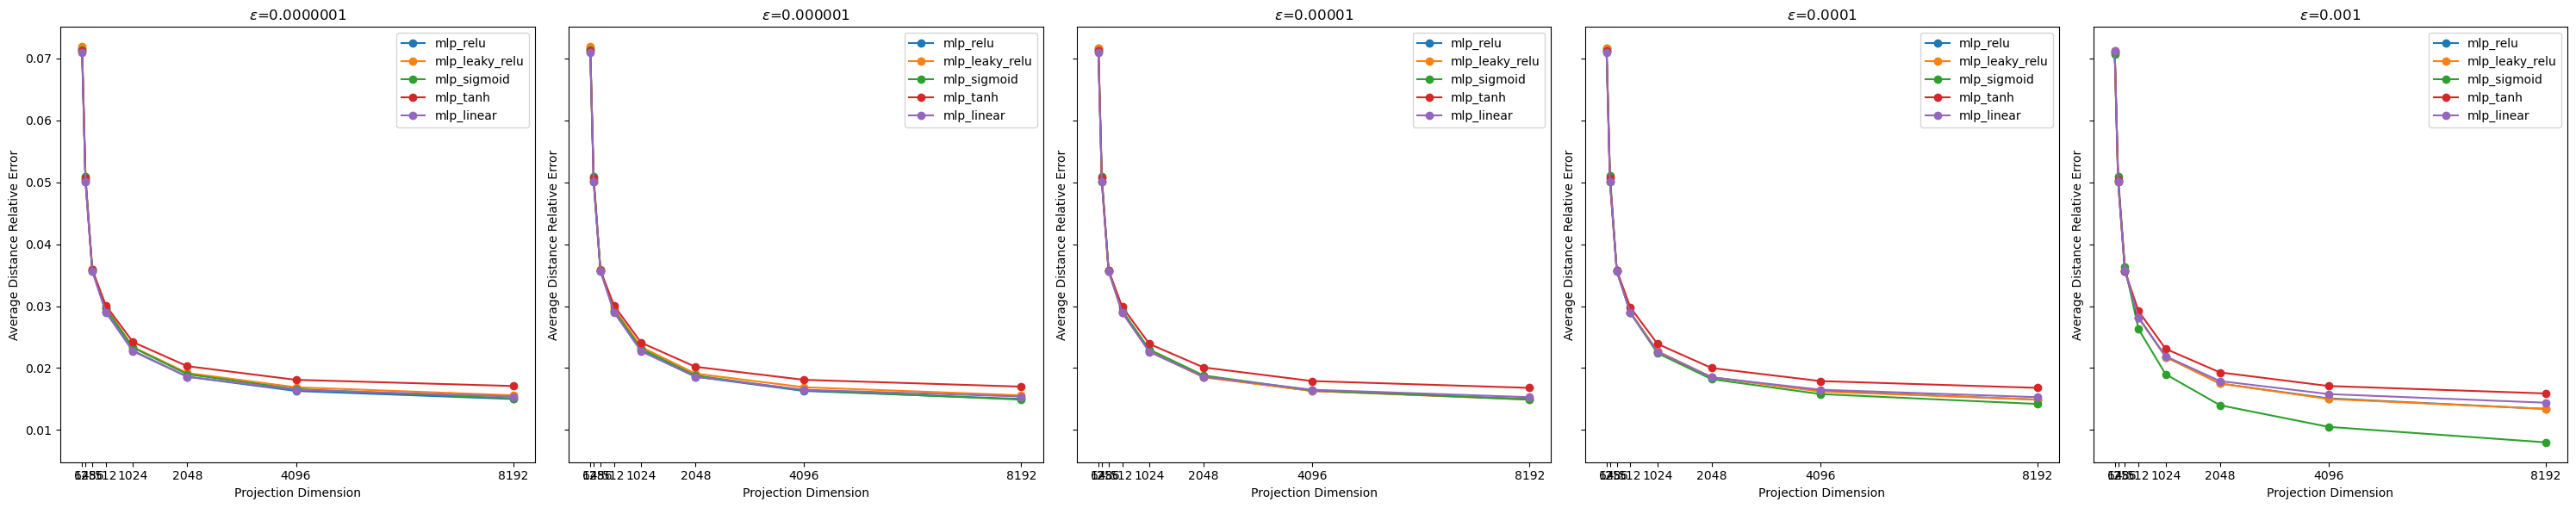

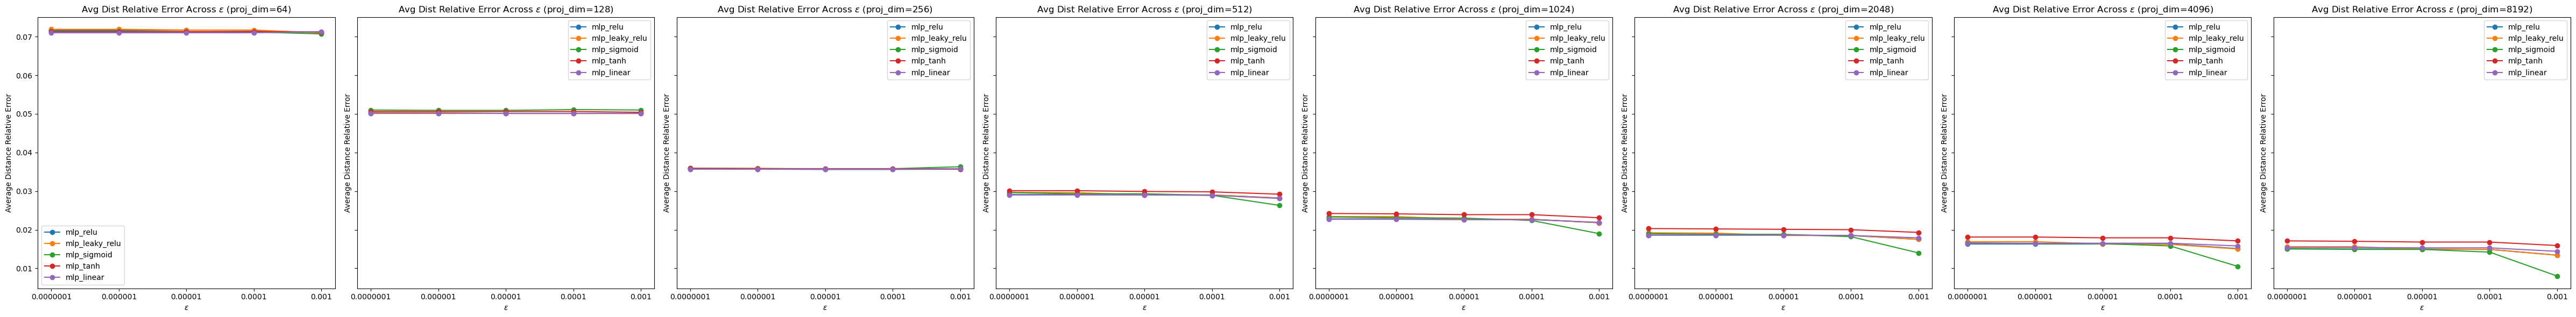

In [15]:
# for metric in ['avg_dist_RE', 'avg_dist_RMSE', 'avg_dist_stress']:
#     plot_metrics_with_threshold(data, projections, eps_list, metric=metric)
#     plot_metrics_with_proj_dim_threshold(data, projections, eps_list, metric=metric)

for metric in ['avg_dist_RE']:
    plot_metrics_with_threshold(data, projections, eps_list, metric=metric)
    plot_metrics_with_proj_dim_threshold(data, projections, eps_list, metric=metric)

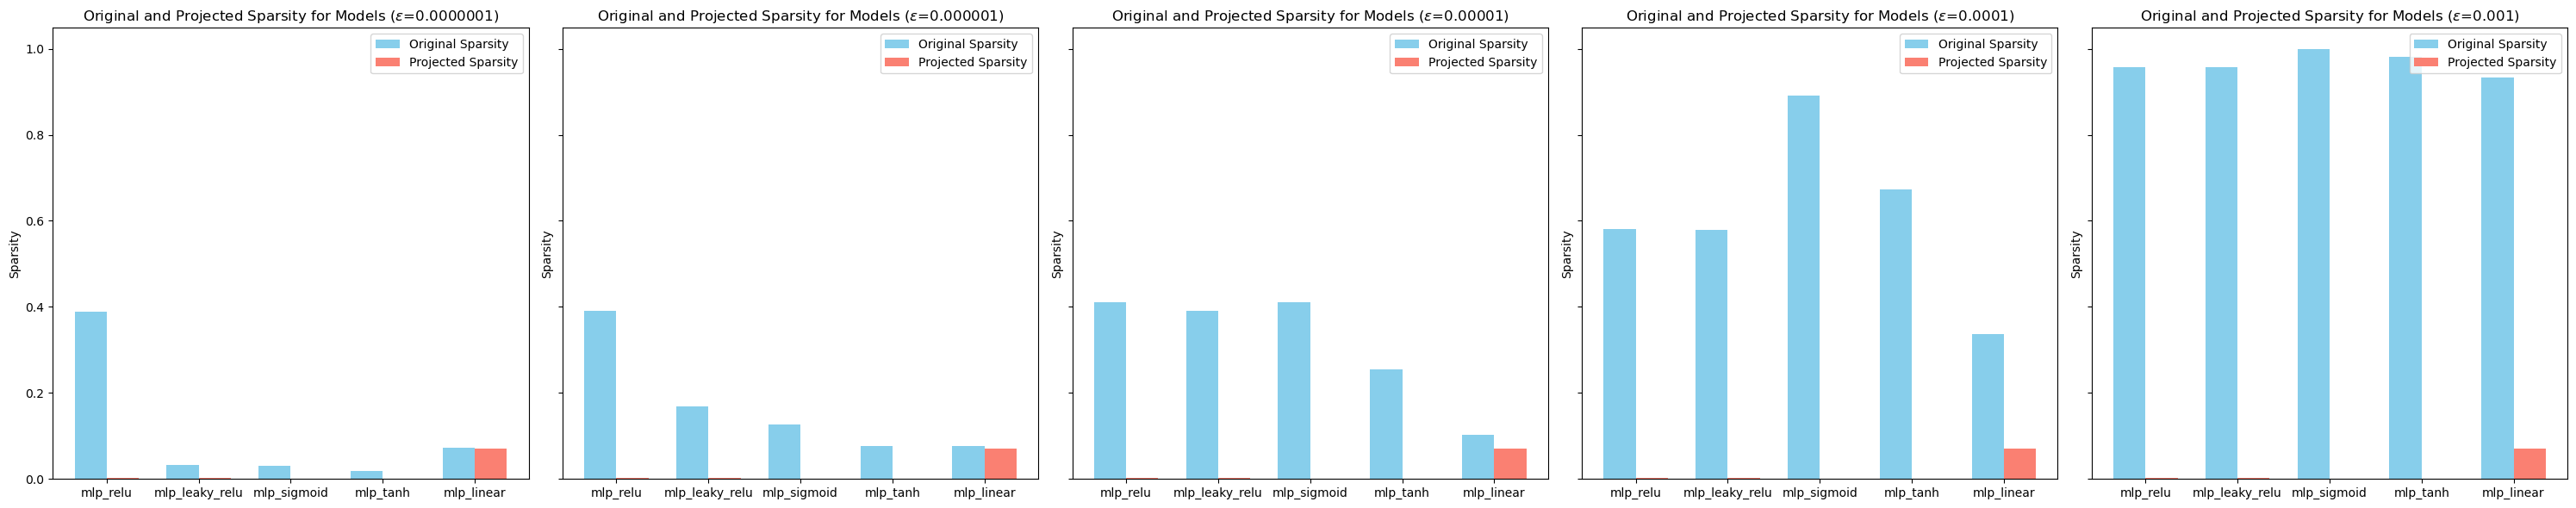

In [16]:
plot_sparsity_with_threshold(data, eps_list)